<h1>mRMR and LDA<h1> 

Authors: 
- Fábio D. Pacheco, up202502538
- Maximino Samarychev, up202107590
- Filipe Ramos, up202208996

Date: 27/11/2025

### Description

This notebook is used for the following purposes:
- Separates the data into a number of k-folds
- Uses the train dataset to apply the mRMR extraction method
- Uses the extraction done by mRMR to apply the LDA model

In [ ]:
#Divide dataset into k-folds
#839 samples
#7-keyfolds de 120


import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt





def divideKFolds(select_keyfold, keyfolds):
    test_fold = keyfolds[select_keyfold]
    X_test = test_fold.iloc[:, 1:]
    y_test = test_fold.iloc[:, 0]
    train_folds = []
    train_labels = []
    
    for i, fold in enumerate(keyfolds):
        #print(f"Fold {i} shape:", fold.shape)
        if(i!= select_keyfold):
            X_fold = fold.iloc[:, 1:]
            y_fold = fold.iloc[:, 0]
            train_folds.append(X_fold)
            train_labels.append(y_fold)
    
    X_train = pd.concat(train_folds, axis = 0)
    y_train = pd.concat(train_labels, axis = 0)
    

    return X_train, y_train, X_test, y_test

df = pd.read_csv('xtrain.csv')
df_labels = pd.read_csv('ytrain.csv')

df.iloc[:, 0] = df_labels.iloc[:, 1]

keyfolds = [ df.iloc[0: 120, :], df.iloc[120: 240, :], df.iloc[240: 360, :],  df.iloc[360: 480, :], df.iloc[480: 600, :], df.iloc[600: 720, :] , df.iloc[720: 840, :]]


select_keyfold = 4

X_train, y_train, X_test, y_test = divideKFolds(4, keyfolds)




<h1> Minimun Redundancy Maximum Relevance</h1>

<h2>Core Ideas of mRMR</h2>
mRMR is based on information theory, specifically Mutual Information (MI)
<h3>1-Mutual Information: </h3>
For two random discrete variables X and Y:

$$I(X;Y) = \sum_{x \in \mathcal{X}} \sum_{y \in \mathcal{Y}} p(x,y) \log \left( \frac{p(x,y)}{p(x)p(y)} \right)$$

<h4>Properties:</h4>
<ul>
    <li>If I(X;Y) = 0, then the varibles are independent.</li>
    <li>For a higher Mutual Information the stronger the dependency.</li>
</ul>
<h3>2-Maximum Relevance</h3>
Let:
<ul>
    <li>fi = candidate feature</li>
    <li>c = class label</li>
    <li>S = Selected feature subset</li>
    <li>|S| = number of selected features</li>
</ul>
The relevance of a feature set S to the class is defined as:

$$D(S, c) = \frac{1}{|S|} \sum_{f_i \in S} I(f_i; c)$$

<h4>Interpretation</h4>
<ul>
    <li>Measures how informative each feature is about the class.</li>
    <li>mRMR aims to maximize this quatity.</li>
</ul>

<h3>3-Minimum Redundancy</h3>
Redundancy measures how much information features share with each other
$$R(S) = \frac{1}{|S|^2} \sum_{f_i \in S} \sum_{f_j \in S} I(f_i; f_j)$$
<h4>Interpretation</h4>
<ul>
 <li>High redundancy means that features are correlated or repetitive</li>
 <li>mRMR aims to minimize this quatity</li>
</ul>
<h3>4-mRMR Objective Function</h3>
mRMR Combines relevance and redundancy into a single criterion:

$$\max \left( D(S, c) - R(S) \right)$$
Which expands to:

$$\max \left( \frac{1}{|S|} \sum_{f_i \in S} I(f_i; c) - \frac{1}{|S|^2} \sum_{f_i, f_j \in S} I(f_i; f_j) \right)$$

In [8]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

class mRMR:
    """
    Minimum Redundancy Maximum Relevance (mRMR) feature selection
    for spectral wavelength data
    """
    
    def __init__(self, n_features=20, method='MID', task='classification'):
        """
        Parameters:
        -----------
        n_features : int
            Number of features to select
        method : str
            'MID' (Mutual Information Difference) or 'MIQ' (Mutual Information Quotient)
        task : str
            'classification' or 'regression'
        """
        self.n_features = n_features
        self.method = method
        self.task = task
        self.selected_features_ = []
        self.scores_ = []
        
    def _mutual_information(self, X, y):
        """Calculate mutual information between features and target"""
        if self.task == 'classification':
            return mutual_info_classif(X, y, random_state=42)
        else:
            return mutual_info_regression(X, y, random_state=42)
    
    def _calculate_redundancy(self, X, selected_idx, candidate_idx):
        """Calculate redundancy between candidate feature and selected features"""
        if len(selected_idx) == 0:
            return 0
        
        redundancy = 0
        for idx in selected_idx:
            # Calculate mutual information between two features
            mi = np.corrcoef(X[:, candidate_idx], X[:, idx])[0, 1] ** 2
            redundancy += mi
        
        return redundancy / len(selected_idx)
    
    def fit(self, X, y):
        """
        Fit mRMR feature selection
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Training data (wavelengths)
        y : array-like, shape (n_samples,)
            Target values (plastic names/codes)
        """
        # Convert to numpy arrays
        if isinstance(X, pd.DataFrame):
            feature_names = X.columns
            X = X.values
        else:
            feature_names = [f'Feature_{i}' for i in range(X.shape[1])]
        
        # Encode target if classification
        if self.task == 'classification':
            if isinstance(y, pd.Series):
                y = y.values
            le = LabelEncoder()
            y = le.fit_transform(y)
        
        n_samples, n_total_features = X.shape
        
        # Calculate relevance (MI between each feature and target)
        print("Calculating feature relevances...")
        relevance = self._mutual_information(X, y)
        
        # Start with the feature with maximum relevance
        selected_idx = [np.argmax(relevance)]
        self.selected_features_ = [feature_names[selected_idx[0]]]
        self.scores_.append(relevance[selected_idx[0]])
        
        
        # Iteratively select features
        remaining_idx = list(set(range(n_total_features)) - set(selected_idx))
        
        for i in range(1, self.n_features):
            mrmr_scores = np.zeros(len(remaining_idx))
            
            for j, candidate_idx in enumerate(remaining_idx):
                # Calculate relevance
                rel = relevance[candidate_idx]
                
                # Calculate redundancy
                red = self._calculate_redundancy(X, selected_idx, candidate_idx)
                
                # Calculate mRMR score
                if self.method == 'MID':
                    mrmr_scores[j] = rel - red
                else:  # MIQ
                    mrmr_scores[j] = rel / (red + 1e-10)
            
            # Select feature with highest mRMR score
            best_idx = np.argmax(mrmr_scores)
            selected_feature_idx = remaining_idx[best_idx]
            
            selected_idx.append(selected_feature_idx)
            self.selected_features_.append(feature_names[selected_feature_idx])
            self.scores_.append(mrmr_scores[best_idx])
            
            remaining_idx.pop(best_idx)
            
        
        return self
    
    def transform(self, X):
        """Transform data to selected features only"""
        if isinstance(X, pd.DataFrame):
            return X[self.selected_features_]
        else:
            # Assuming feature names are numeric (wavelengths)
            selected_idx = [int(feat.split('_')[1]) if '_' in feat else int(feat) 
                          for feat in self.selected_features_]
            return X[:, selected_idx]
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)
    
    def plot_selected_features(self, wavelengths=None):
        plt.figure(figsize=(12, 6))
        
        if wavelengths is None:
            try:
                wavelengths = [float(feat) for feat in self.selected_features_]
            except:
                wavelengths = range(len(self.selected_features_))
        
        plt.subplot(1, 2, 1)
        plt.bar(range(len(self.selected_features_)), self.scores_)
        plt.xlabel('Selection Order')
        plt.ylabel('mRMR Score')
        plt.title('mRMR Scores by Selection Order')
        plt.xticks(range(len(self.selected_features_)), 
                   range(1, len(self.selected_features_) + 1))
        
        plt.subplot(1, 2, 2)
        plt.scatter(wavelengths, self.scores_, s=100, alpha=0.6)
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('mRMR Score')
        plt.title('Selected Wavelengths')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

<h1>Linear Discriminant Analysis </h1>
Linear Discriminant Analysis (LDA) is a supervised learning method used for:
<ul>
<li>Classification</li>
<li>Dimension reduction</li>
</ul>

LDA explicitly uses class labels and tries to find projections that best separate different classes.

<h2>Core Idea</h2>
LDA seeks a linear projection of the data such that:
<ul>
<li>Samples from the same class are close together</li>
<li>Class means are far apart</li>
</ul>

In short, it maximizes between-class variance while minimizing within-class variance.

<h2>Setup and Notation</h2>
<h3>Assume</h3>
<ul>
<li>Dataset with n samples</li>
<li>d-dimensional feature vectors xi ∈ R^d</li>
<li>C classes</li>
<li>Class k has nk samples</li>
</ul>

<h4>Definitions:</h4>
Class mean:

$$\mu_k = \frac{1}{n_k} \sum_{\mathbf{x}_i \in C_k} \mathbf{x}_i$$


Global mean:

$$\mu = \frac{1}{n} \sum_{i=1}^n \mathbf{x}_i$$

<h3>1-Scatter Matrices</h3>
LDA is formulated using scatter matrices rather tan covariance matrices

<h4>Within-Class Scatter Matrix</h4>
Measures how spread out samples are within each class

$$S_W = \sum_{k=1}^C \sum_{\mathbf{x}_i \in C_k} (\mathbf{x}_i - \mu_k)(\mathbf{x}_i - \mu_k)^T$$

<h4>Between-Class Scatter Matrix</h4>
Measures how far class means are from the global mean

$$S_B = \sum_{k=1}^C n_k (\mu_k - \mu)(\mu_k - \mu)^T$$

<h3>2-Optimization Objective <h3>
We want a projection vector w that:
<ul>
<li>Maximizes separation between class means</li>
<li>Minimizes variance within classes</li>
</ul>
This is expressed as a Rayleigh quotient:

$$J(\mathbf{w}) = \frac{\mathbf{w}^T S_B \mathbf{w}}{\mathbf{w}^T S_W \mathbf{w}}$$


<h3>3-Solution via Generalized Eigenvalue Problem</h3>
Maximizing J(w) leads to:

$$S_B \mathbf{w} = \lambda S_W \mathbf{w}$$

<h3>4-Classification Rule</h3>
After projecting:

$$\mathbf{z} = W^T \mathbf{x}$$

Classify using:
<ul>
<li>Nearest class mean.</li>
<li>Or linear discriminant functions:</li>
</ul>

$$\delta_k(\mathbf{x}) = \mathbf{x}^T \Sigma^{-1} \mu_k - \frac{1}{2} \mu_k^T \Sigma^{-1} \mu_k + \log \pi_k$$

where πk​ is the class prior.


<h2> Sumarizing<h2>
LDA finds the linear projections that maximize class separability by maximizing between-class variance relative to within-class variance, leading to a generalized eigenvalue problem.


In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


def train_lda_classifier(X, y, scale_data=True):
    """
    Train LDA classifier on the dataset
    
    Parameters:
    -----------
    X : DataFrame or array
        Feature data (can be mRMR-selected features or all features)
    y : Series or array
        Target labels (plastic names/codes)
    scale_data : bool
        Whether to standardize the data (recommended for LDA)
    
    Returns:
    --------
    lda : LinearDiscriminantAnalysis
        Trained LDA model
    scaler : StandardScaler or None
        Fitted scaler (if scale_data=True)
    X_scaled : array
        Scaled feature data
    y_pred : array
        Predictions on the training data
    """
    print("="*60)
    print("LDA CLASSIFIER TRAINING")
    print("="*60)
    
    # Convert to numpy if needed
    if isinstance(X, pd.DataFrame):
        X_array = X.values
    else:
        X_array = X
    
    if isinstance(y, pd.Series):
        y_array = y.values
    else:
        y_array = y
    
    print(f"\nData shape: {X_array.shape}")
    print(f"Number of samples: {X_array.shape[0]}")
    print(f"Number of features: {X_array.shape[1]}")
    print(f"Number of classes: {len(np.unique(y_array))}")
    print(f"Classes: {np.unique(y_array)}")
    
    # Standardize the data
    if scale_data:
        print("\nStandardizing data...")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_array)
        print("Data standardized (mean=0, std=1)")
    else:
        scaler = None
        X_scaled = X_array
        print("\nUsing original scale (no standardization)")
    
    # Train LDA
    print("\nTraining LDA classifier...")
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_scaled, y_array)
    
    print(f"LDA model trained successfully")
    print(f"Number of LDA components: {lda.n_components}")
    
    # Make predictions on training data
    y_pred = lda.predict(X_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_array, y_pred)
    
    
    return lda, scaler, X_scaled, y_pred


def predict_lda(lda, X, scaler=None):
    """
    Make predictions using trained LDA model
    
    Parameters:
    -----------
    lda : LinearDiscriminantAnalysis
        Trained LDA model
    X : DataFrame or array
        Feature data to predict
    scaler : StandardScaler or None
        Fitted scaler from training
    
    Returns:
    --------
    predictions : array
        Predicted class labels
    probabilities : array
        Prediction probabilities for each class
    """
    # Convert to numpy if needed
    if isinstance(X, pd.DataFrame):
        X_array = X.values
    else:
        X_array = X
    
    # Scale if scaler is provided
    if scaler is not None:
        X_scaled = scaler.transform(X_array)
    else:
        X_scaled = X_array
    
    # Make predictions
    predictions = lda.predict(X_scaled)
    probabilities = lda.predict_proba(X_scaled)
    
    return predictions, probabilities


def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """
    Plot confusion matrix
    
    Parameters:
    -----------
    y_true : array
        True labels
    y_pred : array
        Predicted labels
    title : str
        Plot title
    """
    #plt.figure(figsize=(10, 8))
    
    cm = confusion_matrix(y_true, y_pred)
    classes = np.unique(y_true)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes,
                cbar_kws={'label': 'Count'})
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Print per-class accuracy
    print("\nPer-class accuracy:")
    for i, cls in enumerate(classes):
        class_accuracy = cm[i, i] / cm[i, :].sum()
        print(f"  {cls}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")

def print_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    classes = np.unique(y_true)

    print("\nPer-class accuracy:")
    for i, cls in enumerate(classes):
        class_accuracy = cm[i, i] / cm[i, :].sum()
        print(f"  {cls}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")

def plot_lda_components(lda, X_scaled, y, n_components=2):
    """
    Plot LDA components (projection into LDA space)
    
    Parameters:
    -----------
    lda : LinearDiscriminantAnalysis
        Trained LDA model
    X_scaled : array
        Scaled feature data
    y : array
        Target labels
    n_components : int
        Number of components to plot (max 2 for 2D plot)
    """
    X_lda = lda.transform(X_scaled)
    
    if n_components == 2 and X_lda.shape[1] >= 2:
        plt.figure(figsize=(10, 8))
        classes = np.unique(y)
        
        for cls in classes:
            mask = y == cls
            plt.scatter(X_lda[mask, 0], X_lda[mask, 1], 
                       label=cls, alpha=0.6, s=50)
        
        plt.xlabel('LD1', fontsize=12)
        plt.ylabel('LD2', fontsize=12)
        plt.title('LDA Projection (First 2 Components)', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    elif n_components == 1 or X_lda.shape[1] == 1:
        plt.figure(figsize=(12, 6))
        classes = np.unique(y)
        
        for cls in classes:
            mask = y == cls
            plt.hist(X_lda[mask, 0], alpha=0.5, label=cls, bins=20)
        
        plt.xlabel('LD1', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title('LDA Projection (1st Component)', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()



def evaluate_lda_model(lda, X, y, scaler=None):
    """
    Comprehensive evaluation of LDA model
    
    Parameters:
    -----------
    lda : LinearDiscriminantAnalysis
        Trained LDA model
    X : DataFrame or array
        Feature data
    y : Series or array
        True labels
    scaler : StandardScaler or None
        Fitted scaler
    """
    # Make predictions
    predictions, probabilities = predict_lda(lda, X, scaler)
    
    # Calculate metrics
    accuracy = accuracy_score(y, predictions)
    
    print("="*60)
    print("MODEL EVALUATION")
    print("="*60)
    print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"\nClassification Report:")
    print(classification_report(y, predictions))
    
    # Plot confusion matrix
    plot_confusion_matrix(y, predictions, title="LDA Classification Results")
    
    return predictions, probabilities




In [12]:
# Aplicação com K-folds




# ==========================================
# mRMR
# ==========================================

df = pd.read_csv('xtrain.csv')
df_labels = pd.read_csv('ytrain.csv')

df.iloc[:, 0] = df_labels.iloc[:, 1]

#Select Keyfolds


keyfolds = [ df.iloc[0: 120, :], df.iloc[120: 240, :], df.iloc[240: 360, :],  df.iloc[360: 480, :], df.iloc[480: 600, :], df.iloc[600: 720, :] , df.iloc[720: 840, :]]
accuracies = []

for i in range(7):
    
    X_train, y_train, X_test, y_test = divideKFolds(i, keyfolds)
    
    print("\n" + "="*50)
    print("Applying mRMR Feature Selection")
    print("="*50 + "\n")
    
    selector = mRMR(n_features=20, method='MID', task='classification')
    X_train_selected = selector.fit_transform(X_train, y_train)
    
    
    X_test_selected = selector.transform(X_test)
    
    print(f"Training features: {X_train_selected.shape}")
    print(f"Test features: {X_test_selected.shape}")
    print(f"Selected wavelengths: {selector.selected_features_}")
    
    
    # ==========================================
    # LDA
    # ==========================================
    
    
    
    print("\n" + "="*60)
    print("TRAINING LDA ON SELECTED FEATURES")
    print("="*60 + "\n")
    
    lda, scaler, X_train_scaled, y_train_pred = train_lda_classifier(X_train_selected, y_train, scale_data=True)
    
    y_test_pred, y_test_proba = predict_lda(lda, X_test_selected, scaler)
    
    test_accuracy = accuracy_score(y_test, y_test_pred)
    accuracies.append(test_accuracy)
    print("Fold: ")
    print(i)
    print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print("\nTest Set Classification Report:")
    print(classification_report(y_test, y_test_pred))
    
    #plot_confusion_matrix(y_test, y_test_pred, title = "Test Set Results")
    #print_accuracy(y_test, y_test_pred)

for i in range(7):
    print("Fold: " + str(i) + f" Test Accuracy: ({accuracies[i]*100:.2f}%)")


Applying mRMR Feature Selection

Calculating feature relevances...
Training features: (719, 20)
Test features: (120, 20)
Selected wavelengths: ['767', '2442', '386', '1655', '389', '780', '785', '361', '1659', '493', '2416', '773', '384', '1653', '766', '367', '784', '2411', '385', '774']

TRAINING LDA ON SELECTED FEATURES

LDA CLASSIFIER TRAINING

Data shape: (719, 20)
Number of samples: 719
Number of features: 20
Number of classes: 4
Classes: ['PE' 'PET' 'PP' 'PS']

Standardizing data...
Data standardized (mean=0, std=1)

Training LDA classifier...
LDA model trained successfully
Number of LDA components: None
Fold: 
0
Test Accuracy: 0.4917 (49.17%)

Test Set Classification Report:
              precision    recall  f1-score   support

          PE       0.47      0.50      0.48        28
         PET       0.48      0.77      0.59        39
          PP       0.56      0.41      0.47        37
          PS       0.00      0.00      0.00        16

    accuracy                       

Calculating feature relevances...
Training features: (839, 20)
Test features: (210, 20)
Selected wavelengths: ['530', '2382', '386', '1659', '784', '361', '853', '1452', '384', '794', '2416', '525', '1667', '389', '780', '353', '2352', '785', '717', '1661']

TRAINING LDA ON SELECTED FEATURES

LDA CLASSIFIER TRAINING

Data shape: (839, 20)
Number of samples: 839
Number of features: 20
Number of classes: 4
Classes: ['PE' 'PET' 'PP' 'PS']

Standardizing data...
Data standardized (mean=0, std=1)

Training LDA classifier...
LDA model trained successfully
Number of LDA components: None
Test Accuracy: 0.5952 (59.52%)

Test Set Classification Report:
              precision    recall  f1-score   support

          PE       0.53      0.59      0.56        46
         PET       0.62      0.87      0.72        75
          PP       0.57      0.47      0.52        53
          PS       0.80      0.22      0.35        36

    accuracy                           0.60       210
   macro avg       0.63

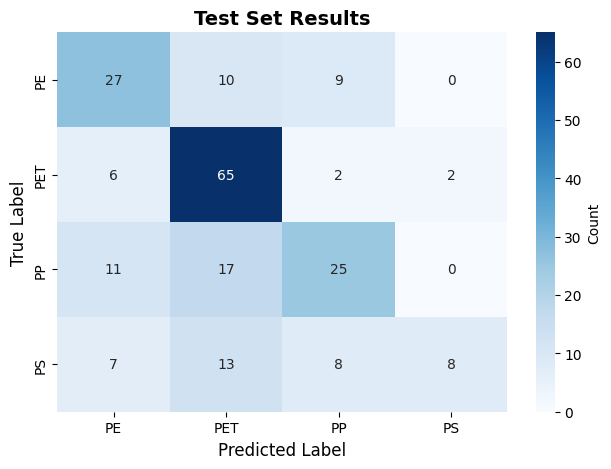


Per-class accuracy:
  PE: 0.5870 (58.70%)
  PET: 0.8667 (86.67%)
  PP: 0.4717 (47.17%)
  PS: 0.2222 (22.22%)


In [11]:
# Aplicação com dataset de treino

df_X_train = pd.read_csv('xtrain.csv')
df_y_train = pd.read_csv('ytrain.csv')

df_X_test = pd.read_csv('xtest.csv')
df_y_test = pd.read_csv('ytest.csv')

X_train = df_X_train.iloc[:, 1:]
y_train = df_y_train.iloc[:,1]

X_test = df_X_test.iloc[:, 1:]
y_test = df_y_test.iloc[:,1]

selector = mRMR(n_features=20, method='MID', task='classification')
X_train_selected = selector.fit_transform(X_train, y_train)


X_test_selected = selector.transform(X_test)

print(f"Training features: {X_train_selected.shape}")
print(f"Test features: {X_test_selected.shape}")
print(f"Selected wavelengths: {selector.selected_features_}")


# ==========================================
# LDA
# ==========================================



print("\n" + "="*60)
print("TRAINING LDA ON SELECTED FEATURES")
print("="*60 + "\n")

lda, scaler, X_train_scaled, y_train_pred = train_lda_classifier(X_train_selected, y_train, scale_data=True)

y_test_pred, y_test_proba = predict_lda(lda, X_test_selected, scaler)

test_accuracy = accuracy_score(y_test, y_test_pred)
accuracies.append(test_accuracy)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

plot_confusion_matrix(y_test, y_test_pred, title = "Test Set Results")

<h1>Conclusions</h3>
The application of mRMR feature combined with LDA for the classification of plastics using hyperspectral data demonstrates that these methods are thoretically sound and practically relevant for a spectral based material discrimination. While mRMR reduces the dimensionality of the spectral data, LDA seeks to maximize class separability in the resulting feature space.Together, these methods provide a structured and interpretable approach for plastic classification.

However the Obtained classification results indicate that model performance is strongly influenced by the number of avaliable samples per class.
Classes with a larger number of samples exhibit significantly higher classification accuracy. For instance PET with the highest number of samples (316), achieves an accuracy of 86.67.
In contrast, PS, which has the smallest number of samples (154), shows a markedly lower accuracy of 22.22%.
A similar trend is observed for PE and PP, where intermediate samples sizes correspond to moderate classification performance.